### Single-channel Source Separation Algorithm
### Matthew Yeseta

### Separate multiple sound sources from a single-channel (mono) recording

Algorithm steps follow these steps:

1. Compute the Spectrogram using the short-time Fourier transform (STFT) of the input signal to get the magnitude spectrogram
2. Initialize NNF basis and activation matrices with non-negative values
3. Update Rules basis (W) and activation (H) matrices using multiplicative update rules
4. Reconstruct Sources the sources by multiplying the basis and activation matrices and transforming back to the time domain
5. Inverse STFT by converting the separated spectrograms back to the time domain using the inverse STFT


### Single-channel Source Separation (ICA)

#### Signal Processing and Analysis Functions

The code provides foundation for signal processing in this effort to analyze audio signals via Fourier transforms and perform NMF for feature extraction or signal separation.
 
The NMF focuses on decomposing a signal into components that will be used in our source separation.
 
check_non_negativity(X): 
  
Checks if all elements in the input matrix X are non-negative, ensuring suitability for NMF.

hann_window(N): 
 
Generates a Hann window of size N. This window function gradually reduces the amplitite of the signal before performing Fourier transforms. hence, reducing edge effects by smoothing the signal.

stft(signal, n_fft, hop_length, window): 
 
Computes the Short-Time Fourier Transform of signal using librosa's stft function. It applies a specified window function, returns the magnitude spectrum. 

dft_matrix(N, signal, process): 
 
Generates matrices based on the process parameter:
 
If process is 'dft', it creates a DFT matrix for transforming a signal.
If process is 'hann', it applies a Hann window to segments of the signal and collects them.
If process is 'inverse', it creates an inverse DFT matrix.
 
nmf_updateH: 
Update function H implements the H using H = H * (W.T @ (X / (W @ H + eps))) / (W.T @ ones_matrix)
 
nmf_updateW: 
Update function W implements the W weights using W = W * ((X / (W @ H)) @ H.T) / (ones_matrix @ H.T)    
signal_reverse(X, N): 
 
Attempts to reconstruct a signal from its processed form, X, considering N as a parameter for the reconstruction process.
 
stft_manual(signal, frame_size, hop_size, N): 
 
Manually computes the STFT of signal, applying a Hann window and creating a matrix of complex Fourier coefficients.
 
#### Non-negative Matrix Factorization (NMF) Functions
 
nmf_updateH and nmf_updateW: 
 
Perform iterative updates for H and W matrices in the NMF algorithm, aimed at decomposing a non-negative matrix X into two matrices (W and H) that approximate X when multiplied together.
 
nmf(X, num_components, provide, activation, max_iterations, tolerance, eps): 
 
Implements NMF given a non-negative matrix X, to factorize it into W (basis matrix) and H (encoding matrix) based on a specified number of components (num_components). It iteratively updates W and H to minimize the approximation error, with optional parameters to influence the initialization and convergence conditions.
 
nfmHW and nfm_H: 
 
Alternative implementations related to NMF, focusing on factorizing X into W and H with specific initializations and update rules. nfHW/nfm_H: implements the W update as W = W @ np.dot(x/np.dot(W,H), and the H update as H = H * (np.dot(W.T, (X/np.dot(W, H))))/(np.dot(W.T, ones_matrix))

In [16]:
import time
from datetime import timedelta as td
import os
import IPython
from scipy.io import wavfile
import scipy.signal
import numpy as np
import random 
import matplotlib.pyplot as plt
from matplotlib import colormaps
import librosa
import seaborn as sns

import numpy as np
import librosa as lb
import librosa 
import pandas as pd
import os
import copy
from sklearn.decomposition import PCA
import IPython
import IPython.display as ipd
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from heapq import heappush
import heapq
import collections
import pandas as pd
from IPython.display import Audio

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [17]:
import librosa as lb
import numpy as np
import matplotlib.pyplot as plt

dir_path = 'C:\\Users\\matth\\Documents\\master-degree\\data'
os.chdir(dir_path)
dir_path = os.getcwd()

data = []
src_rate = 0
for m in range(1,20):
    xica = 'x_ica_' + str(m+1) + '.wav'
    wave, src_rate = lb.load(os.path.join(dir_path, xica), sr = None) 
    data.append(np.array(wave))

    
signal_X = np.asarray(data)



In [18]:
import numpy as np
import librosa as lb
import os

def check_non_negativity(X):
    return np.all(X >= 0)

def hann_window(N):
    return 0.5 - 0.5 * np.cos(2 * np.pi * np.arange(N) / N)

def stft(signal, n_fft=2048, hop_length=512, window='hann'):
    S = np.abs(lb.stft(signal, n_fft=n_fft, hop_length=hop_length, window=window))
    return S


def dft_matrix(N, signal, process):
    if process == 'dft': 
        n = np.arange(N)
        k = n.reshape((N, 1))
        result = np.exp(-2j * np.pi * k * n / N)
    if process == 'hann':
        db = []; i = 0
        while i+N <= len(signal):
            signal_window = signal[i:i+N]
            hann = hann_window(N)
            signal_vector = np.multiply(signal_window, hann)
            db.append(signal_vector)
            i = i + int(N/2)
        db = np.array(db)
        result = db.T 
    if process == 'inverse': 
         result = np.array([[np.exp(1j*(2*np.pi*f*n/N)) for f in range(0,N)] for n in range(0,N)])/N
            
    return result

def signal_reverse(X, N):
    X_out = X[:(X.shape[0] - int(N/2)),0]
    for col in range(1,X.shape[1]):
        X_col = X[(X.shape[0] - int(N/2)):,col-1] + X[0:int(N/2),col]
        X_out = np.concatenate((X_out,X_col))
    
    X_out = X_out.reshape(-1)
    
    return X_out

def stft(signal):
    """Source: vectorized Cooley-Tukey FFT algorithm"""
    signalX = np.array(signal, dtype=float)
    S = np.array(signalX.shape[0])
    F_constraint = min(S, 32)
    dftK = S[:, None]
    f = np.arange(F_constraint)
    dft = np.exp(-2j * dftK / F_constraint * np.pi * f)
    signalX = np.dot(dft, signalX.reshape((F_constraint, -1)))
    while signalX.shape[0] < S:
        signalX_even = signalX[:, :signalX.shape[1] / 2]
        signalX_odd = signalX[:, signalX.shape[1] / 2:]
        signalX_factor = np.exp(-1j * np.arange(signalX.shape[0] * np.pi)) / np.arange(signalX.shape[0].shape[0])[:, None]
        signalX = np.vstack([signalX_even + signalX_factor * signalX_odd, signalX_even - signalX_factor * signalX_odd])
                                
    X = np.abs(signalX)

    return X.ravel()

def stft_manual(signal, frame_size, hop_size, N):
    if N is None:
        N = frame_size  
    
    num_frames = 1 + int((len(signal) - frame_size) / hop_size)
    window = hann_window(frame_size)
    stft_matrix = np.zeros((num_frames, N), dtype=complex)
    
    for i in range(num_frames):
        start_index = i * hop_size
        end_index = start_index + frame_size
        frame = signal[start_index:end_index] * window
        padded_frame = np.zeros(N)
        padded_frame[:len(frame)] = frame
        stft_matrix[i, :] = np.dot(dft_matrix(N, signal, 'dft'), padded_frame)
        
    return np.abs(stft_matrix)

def nmf_updateH(X, W, H, num_components, eps=1e-20):
    F, T = X.shape
    ones_matrix = np.ones((F, T))
    H = H * (W.T @ (X / (W @ H + eps))) / (W.T @ ones_matrix)
    return H

def nmf_updateW(X, W, H, num_components):
    F, T = X.shape
    ones_matrix = np.ones((F, T))
    W = W * ((X / (W @ H)) @ H.T) / (ones_matrix @ H.T)    
    return W

def nmf(X, num_components, provide=False, activation=0, max_iterations=1000, tolerance=1e-5, eps=1e-20):
    if not check_non_negativity(X):
        raise ValueError("matrix X must be non-negative.")
     
    F, T = X.shape;H=0;W=0
    W = np.random.rand(F, num_components)
    H = np.random.rand(num_components, T)
    if (provide): 
        H = np.random.rand(num_components, X.shape[1])[0:513,:]
    nmf_prev_error = np.inf   
    if (provide): 
        H = np.random.rand(60, X.shape[1]) 
        ones_matrix = np.ones(X.shape) 
        for k in range(0, 2000):
            H = H * (np.dot(W.T, (X/np.dot(W, H))))/(np.dot(W.T, ones_matrix))
            W = nmf_updateW(X, activation, H, num_components)
            if np.abs(nmf_prev_error - error) < tolerance: break #1
        WH = W @ H
        error = np.sum(X * np.log((X + eps) / (WH + eps)) - X + WH)        
    else:
        for i in range(max_iterations): 
            H = nmf_updateH(X, W, H, num_components, eps)
            W = nmf_updateW(X, W, H, num_components)
        WH = W @ H
        error = np.sum(X * np.log((X + eps) / (WH + eps)) - X + WH)        
        
    nmf_prev_error = error         
    H = np.abs(H)
    W = np.abs(W)
    return W, H, error

def nfmHW(X, N):
    W = np.random.rand(X.shape[0], N) 
    H = np.random.rand(N, X.shape[1]) 
    ones_matrix = np.ones(X.shape) 
    for i in range(0, 2000):
        W = W @ np.dot(x/np.dot(W,H), H.T), (1/np.doc(ones_matrix, H.T))
        H = H * (np.dot(W.T, (X/np.dot(W, H))))/(np.dot(W.T, ones_matrix))
        
    return W, H

def nfm_H(X, K, W):
    H = np.random.rand(K, X.shape[1]) 
    ones_matrix = np.ones(X.shape) 
    for i in range(0, 2000):
        H = H * (np.dot(W.T, (X/np.dot(W, H))))/(np.dot(W.T, ones_matrix))
        
    return H


### Signal processing

Load an audio signal, performing spectral analysis through Discrete Fourier Transform (DFT), applying a Hann window to the signal, and finally, decomposing the resulting spectrogram using Non-negative Matrix Factorization (NMF)

#### Fourier Transform and Windowing:

matrix = dft_matrix(N, signal_X, 'dft'): 
 
Calls a function to compute the DFT matrix for the signal. This creates a basis for Fourier transform 
 
matrix_hann = dft_matrix(N, signal_X, 'hann'): 
 
Generates a Hann window of length N applied to the signal. 
  
matrix_spectogram = np.dot(matrix, matrix_hann): 
 
Calculates the dot product of the DFT matrix and the Hann window matrix, intended to produce a spectrogram. The Hann window is applied directly to segments of the signal before computing the DFT of each segment.
 
#### Spectrogram Processing:

matrix_spectogram_half = matrix_spectogram[0:513,:]: 
 
Slices the first 513 rows of the spectrogram, assuming a symmetrical spectrum with redundant information past the Nyquist frequency.
 
S = np.abs(matrix_spectogram_half): 
 
Computes the magnitude spectrogram, which is the absolute value of the complex Fourier coefficients.
Non-negative Matrix Factorization:
 
W_S, H_S, final_error = nmf(S, num_components, provide=False): 
 
Performs NMF on the magnitude spectrogram S to decompose it into W_S (basis matrix) and H_S (activation matrix), retaining num_components components. This step is crucial for feature extraction, dimensionality reduction, or source separation, with final_error capturing the approximation error of the decomposition.

In [19]:
signal_X, src_rate = lb.load(os.path.join(dir_path, 'trs.wav'), sr=None)

N = 1024
n_frame = 2048
hop_length = 512
num_components = 30

matrix = dft_matrix(N, signal_X, 'dft')
matrix_hann = dft_matrix(N, signal_X, 'hann')
matrix_spectogram = np.dot(matrix, matrix_hann)
matrix_spectogram_half = matrix_spectogram[0:513,:]
S = np.abs(matrix_spectogram_half)
W_S, H_S, final_error = nmf(S, num_components, provide=False)


In [20]:
print("Final error:", final_error)
print("W (Basis matrix):", W_S.shape)
print("H (Encoding matrix):", H_S.shape)

Final error: 19642.073084911408
W (Basis matrix): (513, 30)
H (Encoding matrix): (30, 987)


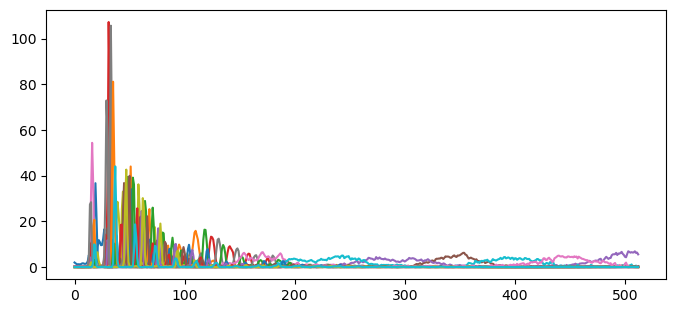

In [21]:
plt.figure(figsize=(8, 3.5))
plt.plot(W_S)
plt.show()
W_S_model = W_S
H_S_model = H_S
final_err_trs = final_error

In [22]:
signal_X, src_rate = lb.load(os.path.join(dir_path, 'trn.wav'), sr=None)

n_frame = 2048
hop_length = 512
num_components = 30

matrix = dft_matrix(N, signal_X, 'dft')
matrix_hann = dft_matrix(N, signal_X, 'hann')
matrix_spectogram = np.dot(matrix, matrix_hann)
matrix_spectogram_half = matrix_spectogram[0:513,:]
S = np.abs(matrix_spectogram_half)
W_N, H_N, final_error = nmf(S, num_components, provide=False)

In [23]:
print("Final error:", final_error)
print("W (Basis matrix):", W_S.shape)
print("H (Encoding matrix):", H_S.shape)

Final error: 53321.12509810396
W (Basis matrix): (513, 30)
H (Encoding matrix): (30, 987)


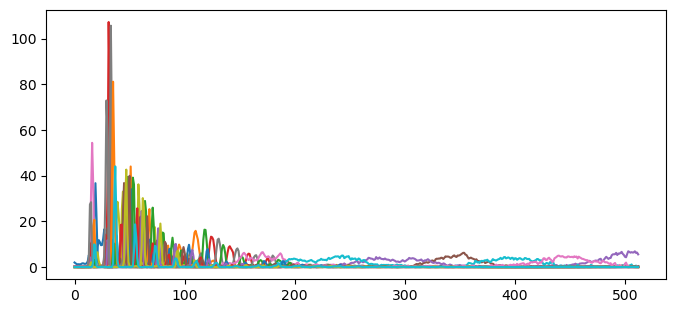

In [24]:
plt.figure(figsize=(8, 3.5))
plt.plot(W_S)
plt.show()
W_S_model = W_S
H_S_model = H_S
final_err_trs = final_error

### Invert the masked spectrogram back to the time domain

#### Signal Mask Creation:

signal_mask = np.dot(W_S, H[0:30, :])/np.dot(W, H): 
 
Creates a mask by multiplying the NMF basis matrix W_S with the first 30 components of the encoding matrix H, then divides this by the product of the full basis matrix W and encoding matrix H. Isolate specifics of the voice of interest from the magnitude spectrogram by emphasizing certain frequencies over others.
 
Signal Estimation:
 
signal_est = signal_mask * matrix_spectogram_half: 
  
Applies the mask to the magnitude spectrogram to effectively filter a spectrogram to emphasize the desired components.
 
Conjugate Symmetry for Inverse FFT:

signal_conjugate = np.flip(np.conjugate(signal_est[1:512, :]), axis=0): 
 
Generates the conjugate symmetric part of the spectrum. Since the Fourier transform of a real signal is conjugate symmetric, this step prepares for a correct inverse Fourier transform by ensuring the synthesized spectrum has this same attribute. The signal is flippe, and conjugated on all but the first row of the signal in 'signal_est' to create the lower half of the spectrum.
 
#### Signal Reconstruction:

signal_voice = np.concatenate((signal_est, signal_conjugate), axis=0): 
 
Concatenates the estimated spectrum with its conjugate symmetric part to form a complete spectrum that is ready for inverse Fourier transformation.

signal_recovered = np.dot(dft_matrix(N, signal_voice, 'dft'), signal_voice): 
 
Applies the inverse Discrete Fourier Transform (DFT) to the full spectrum to reconstruct the signal in the time domain. 

#### Overlap-Add Method:

signal_overlap_time_domain = signal_reverse(signal_recovered.real, N): 
 
After obtaining the real part of the reconstructed signal (signal_recovered.real), this apply the overlap-add method to handle the overlapping frames in the time-domain signal reconstruction. 


In [25]:
signal_mask = np.dot(W_S, H_N[0:30, :])/np.dot(W_S, H_S)
signal_est = signal_mask * matrix_spectogram_half
signal_conjugate = np.flip(np.conjugate(signal_est[1:512, :]), axis = 0)
signal_voice = np.concatenate((signal_est, signal_conjugate), axis = 0)
signal_recovered = np.dot(dft_matrix(N, signal_voice, 'dft'), signal_voice)
signal_overlap_time_domain = signal_reverse(signal_recovered.real, N)

#### Original Signal and Denosed Signal 
#### 1st voice: signal_X, original signal audio data
#### 2nd voice: signal_overlap_time_domain, signal recoverd and reversed on overlap time domain

W_S and W_N are trained and we find that results have significant denoised results across the spectrume, with only a few unaffected at frequency 15,000, 23,000, 42,000. Ws and Wn become nearly equal in many of the frequencies from 0 to 60,000 

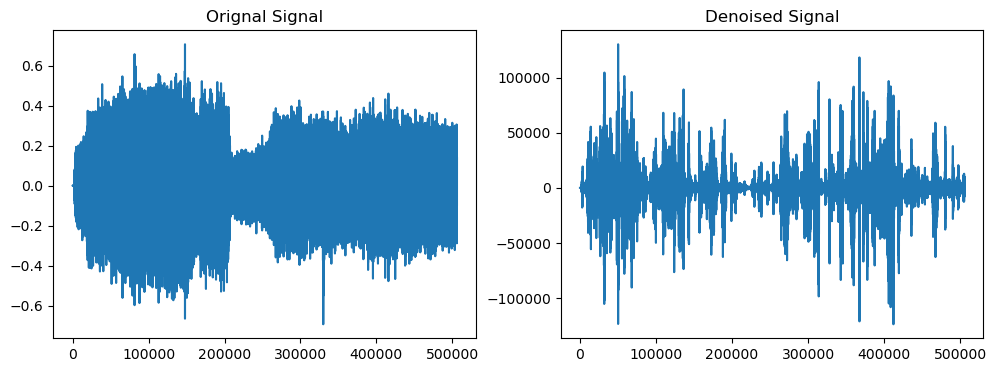

In [26]:
fig, axis = plt.subplots(1,2, figsize=(12,4))
x_axis = range(signal_X.shape[0])
axis[0].set_title('Orignal Signal')
axis[0].plot(x_axis, signal_X)
x_axis = range(signal_overlap_time_domain.shape[0])
axis[1].set_title('Denoised Signal')
axis[1].plot(x_axis, signal_overlap_time_domain)
plt.show()

In [27]:
from IPython.display import Audio
print("Audio")
display(Audio(signal_X, rate=src_rate))

Audio


In [28]:
from IPython.display import Audio
print("Audio")
display(Audio(signal_overlap_time_domain, rate=src_rate))

Audio
